In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.implants as p2pi
import pulse2percept.retina as p2pr
import pulse2percept.utils as p2pu

import skimage.io as skio
import skimage.transform as skit

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-06-15 16:03:57,694 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
results_dir = '../../results/shape1cv/'
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjectdata['scale'] = pd.Series([0.5, 1.5, 1.0, 0.6], index=subjectdata.index)
subjectdata

,second_sight_id,implant_x,implant_y,implant_rot,loc_od_x,loc_od_y,xrange,yrange,implant_type,scale
subject_id,,,,,,,,,,
S1,TB,-406,-162,-0.698,17.7,1.680,"(-36.9, 36.9)","(-36.9, 36.9)",<class 'pulse2percept.implants.ArgusI'>,0.5
S2,12-005,-1725,-366,-0.474,15.3,0.922,"(-30.0, 30.0)","(-22.5, 22.5)",<class 'pulse2percept.implants.ArgusII'>,1.5
S3,51-009,249,-486,-0.609,15.0,1.790,"(-32.5, 32.5)","(-24.4, 24.4)",<class 'pulse2percept.implants.ArgusII'>,1.0
S4,52-001,-1502,-227,-0.415,16.9,2.500,"(-32.0, 32.0)","(-24.0, 24.0)",<class 'pulse2percept.implants.ArgusII'>,0.6


In [3]:
subjects = subjectdata.index.sort_values()

In [4]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        [row.update(bp) for bp in best_params]
        data.append(row)
    return pd.DataFrame(data)

In [5]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
#         xyrange = np.array([np.diff(subjectdata.loc[subject, 'xrange'])[0],
#                             np.diff(subjectdata.loc[subject, 'yrange'])[0]])
        y_test = pd.DataFrame([{'image': row['image'].values[0],
                                'img_shape': row['image'].values[0].shape,
                                'electrode': row['electrode'].values[0],
                                'area': float(row['area']),# / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'image': row['image'].values[0],
                                'img_shape': row['image'].values[0].shape,
                                'electrode': row['electrode'].values[0],
                                'area': float(row['area']),# / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity'])}
                               for row in data['y_pred']], index=data.index)
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])
                            
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.drop(columns=['image', 'img_shape', 'electrode']).columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [6]:
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 480 files


In [7]:
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [8]:
data = load_data(pickle_files, verbose=False)

In [9]:
data = data.loc[np.logical_not(data.model == 'C2'), :]

In [10]:
data.columns

Index(['axlambda', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'rho', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [11]:
# Group by these:
groupcols = ['subject', 'model']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity']
r2cols = ['r2_%s' % name for name in predcols]

In [12]:
data.groupby(groupcols + ['idx_fold'], sort=False).agg({'best_train_cost': ['count', 'mean', 'std'],
                                                        'rho': ['mean', 'std'],
                                                        'axlambda': ['mean', 'std']})

rho             best_train_cost              \
                              mean         std           count        mean   
subject model idx_fold                                                       
S1      A     0         494.664570   30.302480               3  176.109008   
              1         594.107611   94.320095               3  148.149534   
              2         573.995356  107.716475               3  306.807340   
              3         528.344205   28.404138               3  158.941912   
              4         543.926742   55.917327               3  150.090607   
              5         531.315790   32.321309               3  146.226372   
              6         511.973825    0.555822               3  148.351500   
              7         574.607845  107.358582               3  168.346153   
              8         530.948582   32.617179               3  143.410650   
              9         511.698075    0.020698               3  156.065232   
        C     0         294.781231   39.488748               5    9.086925   
              1         308.649321    9.448570               5    5.561622   
              2         200.664728   44.514041               5    6.856116   
              3         232.238452    1.771853               5    5.864281   
              4         309.686420   14.601171               5    5.526420   
              5         251.731161   29.840751               5    6.043272   
              6         233.697324    0.980747               5    6.955214   
              7         233.582643    1.064609               5    7.031689   
              8         241.769271   18.372590               5    5.941942   
              9         259.859562   20.637003               5    5.843728   
S2      A     0         497.124910    0.400785               3   14.837680   
              1         517.038292   17.843989               3   15.577688   
              10        520.140268   22.161593               3   15.105456   
              11        513.227207   24.616003               3   15.323759   
              12        524.608483   15.191435               3   14.567804   
              13        538.708621    6.960520               3   14.977147   
              14        525.047981    6.716782               3   14.413686   
              15        499.533869   17.482757               3   15.922910   
              16        515.670996   52.047893               3   14.821234   
              17        524.974483   30.344533               3   22.122460   
...                            ...         ...             ...         ...   
S4      A     16        771.875740   24.211158               3   20.849448   
              17        724.017507   24.183806               3   20.663456   
              18        779.328349   74.858839               3   21.209974   
              2         796.329283   57.587604               3   21.334350   
              3         761.689360   82.092875               3   22.115042   
              4         801.977387   20.675162               3   19.885884   
              5         755.630613   24.478620               3   20.335124   
              6         767.023223   23.007206               3   20.846638   
              7         822.784683   94.754170               3   21.812470   
              8         771.282381   23.735134               3   20.156732   
              9         801.547284   49.185200               3   20.972478   
        C     0         471.774588   43.839106               5    4.449543   
              1         431.647547   81.840500               5    4.800954   
              10        437.934147   56.518660               5    5.560126   
              11        561.567589   26.559058               5    4.642144   
              12        497.888581   79.805385               5    4.625282   
              13        525.533716   66.434247               5    4.501856   
              14        489.307983   77.798658       

# The best runs in their respective category

In [13]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])
gb.agg({'best_train_cost': ['count', 'min'], 'rho': 'mean', 'axlambda': 'mean'})

Best scores:


rho best_train_cost                 axlambda
                              mean           count         min         mean
subject model idx_fold                                                     
S1      A     0         459.678237               1  174.740706          NaN
              1         515.146557               1  144.818625          NaN
              2         511.682707               1  301.878179          NaN
              3         511.946741               1  155.063336          NaN
              4         511.634455               1  141.974382          NaN
              5         512.619473               1  143.469994          NaN
              6         512.614117               1  148.201546          NaN
              7         512.623776               1  165.140639          NaN
              8         512.620074               1  141.185584          NaN
              9         511.680618               1  156.065232          NaN
        C     0         325.099614               1    8.988158  2735.652851
              1         317.204467               1    5.453661  2503.285347
              2         219.678382               1    6.724565  1879.847102
              3         232.371795               1    5.818401  2633.548195
              4         311.536669               1    5.391106  3000.000000
              5         234.765836               1    5.992426  2560.161571
              6         234.716425               1    6.939133  2840.808938
              7         234.196499               1    7.007276  2871.420855
              8         234.534015               1    5.880647  2871.093834
              9         274.722318               1    5.756206  2704.973282
S2      A     0         497.386393               1   14.738361          NaN
              1         496.701497               1   15.544402          NaN
              2         510.128267               1   15.050400          NaN
              3         497.403685               1   15.085975          NaN
              4         524.336639               1   15.259691          NaN
              5         574.522025               1   15.354731          NaN
              6         510.088589               1   14.671961          NaN
              7         474.347225               1   14.632983          NaN
              8         510.088084               1   14.989083          NaN
              9         509.563552               1   14.453286          NaN
...                            ...             ...         ...          ...
S4      A     8         778.151875               1   20.120777          NaN
              9         829.585781               1   20.914516          NaN
              10        813.941895               1   30.415640          NaN
              11        744.866893               1   19.907096          NaN
              12        829.583025               1   20.914370          NaN
              13        778.245158               1   21.159948          NaN
              14        813.968077               1   20.568784          NaN
              15        813.914415               1   21.837750          NaN
              16        782.655603               1   20.481752          NaN
              17        744.767034               1   20.507775          NaN
              18        813.968458               1   20.862487          NaN
        C     0         503.355784               1    4.385385  2498.689209
              1         561.819839               1    4.469040   415.678149
              2         552.391211               1    4.326538   463.644441
              3         544.702195               1    4.458065   573.365219
              4         397.017443               1    4.682888  2570.475727
              5         593.749897               1    4.497260   505.728337
              6         573.895898               1    4.421025   472.503812
              7         572.663577               1    4.533462   440.872838
   

In [14]:
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols)
gb.agg({'rho': ['mean', 'std'], 'axlambda': ['mean', 'std']})

rho                axlambda            
                     mean        std         mean         std
subject model                                                
S1      A      507.224675  16.737530          NaN         NaN
        C      261.882602  41.267627  2660.079198  314.318059
S2      A      510.725922  23.915135          NaN         NaN
        C      437.212226  44.005119   286.523781   31.881896
S3      A      172.046859   0.192174          NaN         NaN
        C       52.067722   2.973407   728.672843  682.775900
S4      A      796.806168  29.234295          NaN         NaN
        C      538.711078  57.262756   698.518859  650.786975

In [15]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

,best_test_cost,model,r2_area,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,167.562065,A,-1.928703,-159.843214,-2.790149,S1,area eccentricity electrode \ 0 243.0...,area eccentricity electrode \ 0 248...
1,6.854980,C,-2.048375,-1.376025,-0.430579,S1,area eccentricity electrode \ 32 558.0...,area eccentricity electrode \ 32 248...
2,17.030317,A,-0.160343,-12.410396,-1.459578,S2,area eccentricity electrode \ 81 30...,area eccentricity electrode \ 81 34...
3,4.958757,C,-1.325528,-1.046000,0.412771,S2,area eccentricity electrode \ 137 28...,area eccentricity electrode \ 137 34...
4,11625.858999,A,-0.533560,-11618.860738,-3.464702,S3,area eccentricity electrode \ 224 308...,area eccentricity electrode \ 224 4...
5,7.242630,C,-2.547740,-0.779832,-0.915057,S3,area eccentricity electrode \ 267 3...,area eccentricity electrode \ 267 4...
6,21.297549,A,-0.074967,-18.282683,0.060101,S4,area eccentricity electrode \ 329 71...,area eccentricity electrode \ 329 ...
7,5.629677,C,-1.605231,-1.166850,0.142404,S4,area eccentricity electrode \ 389 1...,area eccentricity electrode \ 389 ...


# Plot predictions

In [16]:
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
all_ticks = (([0, 2400], [-90, 90], [0, 1]),
             ([0, 6000], [-90, 90], [0, 1]),
             ([0, 2000], [-90, 90], [0, 1]),
             ([0, 18000], [-90, 90], [0, 1]))
labels = ['area (pixels$^2$)', 'orientation (deg)', 'elongation']

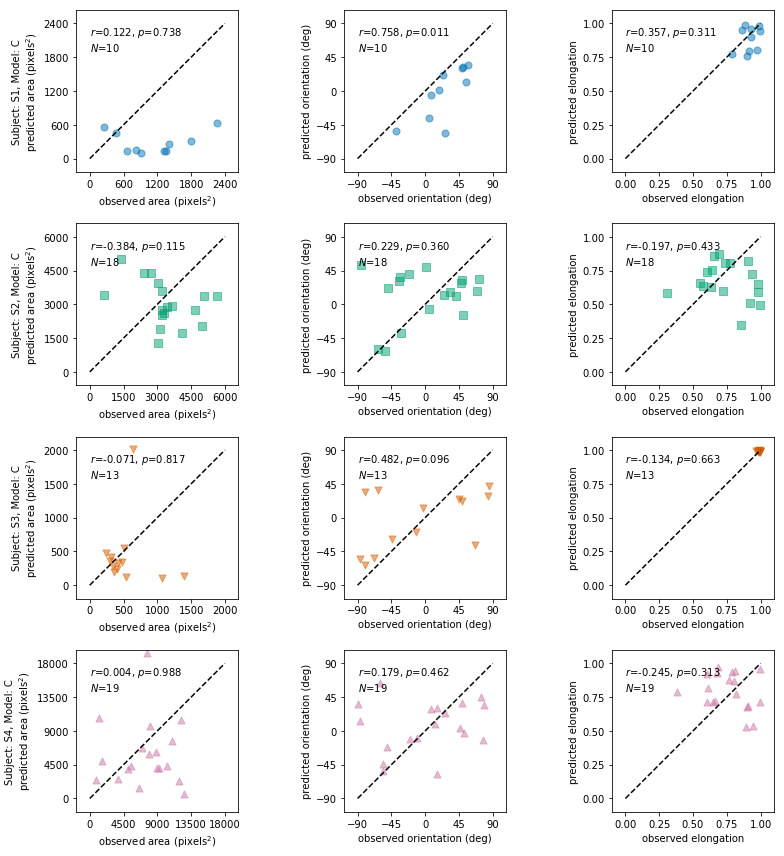

In [17]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(12, 3 * len(subjects)))
for subject, marker, color, ticks, axrow in zip(subjects, markers, colors, all_ticks, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, label in zip(predcols, axrow, ticks, labels):
            lim = [1.1 * tick[0] - 0.1 * tick[1], 1.1 * tick[1] - 0.1 * tick[0]]
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.axis('square')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            if pval >= 0.001:
                ax.text(tick[0], tick[1], "$r$=%.3f, $p$=%.3f\n$N$=%d\n" % (rval, pval, len(y)), 
                        va='top', ha='left')
            else:
                ax.text(tick[0], tick[1], "$r$=%.3f, $p$=%.2e\n$N$=%d" % (rval, pval, len(y)), 
                        va='top', ha='left')
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (subject, plotmodel, labels[0]))
fig.tight_layout()
fig.savefig('fig7-scatter-%s.eps' % plotmodel)
fig.savefig('fig7-scatter-%s.png' % plotmodel)

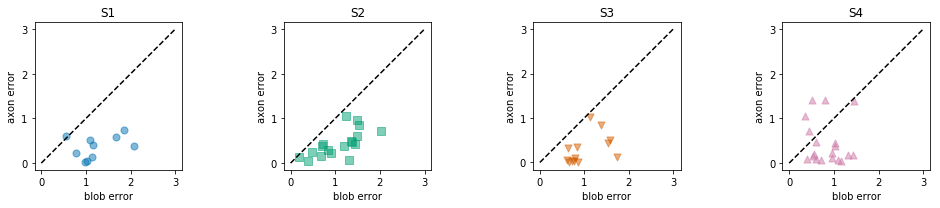

In [18]:
fig, axes = plt.subplots(ncols=len(subjects), figsize=(14, 3))
for subject, marker, color, ax in zip(subjects, markers, colors, axes):
    best_blob = best[np.logical_and(best['subject'] == subject, best['model'] == 'A')]
    best_axon = best[np.logical_and(best['subject'] == subject, best['model'] == 'C')]
    errb = 0
    erra = 0
    for col in predcols:
        yb = (best_blob['y_pred'].values[0][col] - best_blob['y_test'].values[0][col]) ** 2
        ya = (best_axon['y_pred'].values[0][col] - best_axon['y_test'].values[0][col]) ** 2
        ymax = np.max([yb.max(), ya.max()])
        errb += yb / ymax
        erra += ya / ymax
    ax.scatter(errb, erra, marker=marker, s=50, c=color, alpha=0.5)
    ax.set_xlabel('blob error')
    ax.set_ylabel('axon error')
    ax.plot([0, 3], [0, 3], 'k--')
    ax.set_xticks(np.linspace(0, 3, 4))
    ax.set_yticks(np.linspace(0, 3, 4))
    ax.axis('square')
    ax.set_title(subject)
fig.tight_layout()

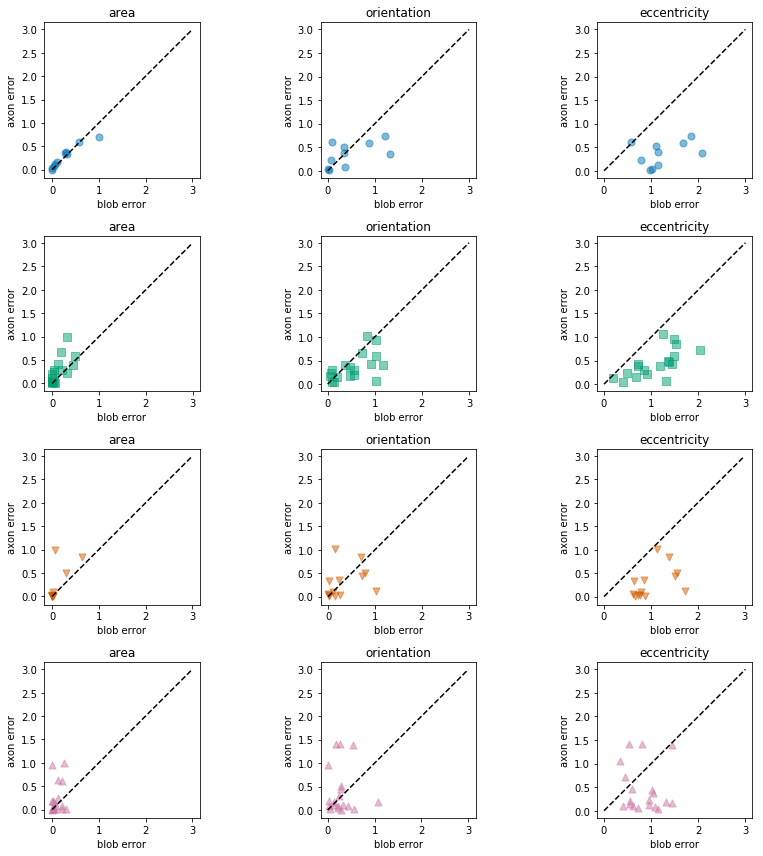

In [19]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=len(predcols), figsize=(12, 3 * len(subjects)))
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    best_blob = best[np.logical_and(best['subject'] == subject, best['model'] == 'A')]
    best_axon = best[np.logical_and(best['subject'] == subject, best['model'] == 'C')]
    errb = 0
    erra = 0
    for col, ax in zip(predcols, axrow):
        yb = (best_blob['y_pred'].values[0][col] - best_blob['y_test'].values[0][col]) ** 2
        ya = (best_axon['y_pred'].values[0][col] - best_axon['y_test'].values[0][col]) ** 2
        ymax = np.max([yb.max(), ya.max()])
        errb += yb / ymax
        erra += ya / ymax
        ax.scatter(errb, erra, marker=marker, s=50, c=color, alpha=0.5)
        ax.set_xlabel('blob error')
        ax.set_ylabel('axon error')
        ax.plot([0, 3], [0, 3], 'k--')
        ax.axis('square')
        ax.set_title(col)
fig.tight_layout()

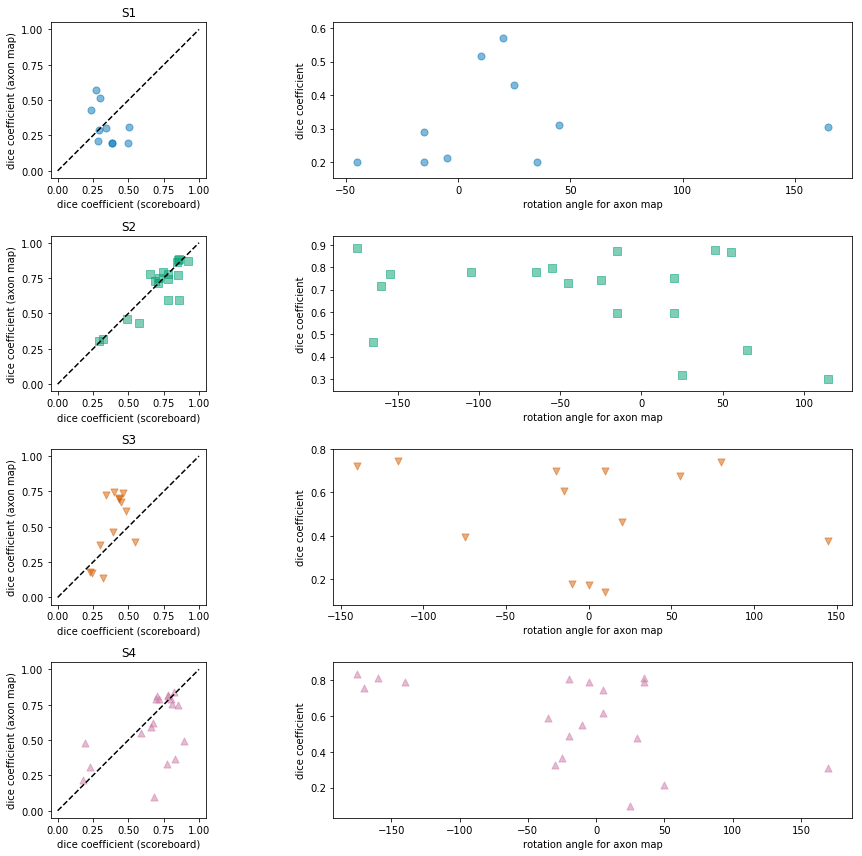

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=len(subjects), figsize=(14, 3 * len(subjects)))
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    best_blob = best[np.logical_and(best['subject'] == subject, best['model'] == 'A')]
    best_axon = best[np.logical_and(best['subject'] == subject, best['model'] == 'C')]
    for (_, fold_b), (_, fold_a) in zip(best_blob.iterrows(), best_axon.iterrows()):
        dice_b = [argus_shapes.imgproc.dice_coeff(argus_shapes.imgproc.center_phosphene(y['image']),
                                                  argus_shapes.imgproc.center_phosphene(yb['image'])) 
                  for (_, y), (_, yb) in zip(fold_b['y_test'].iterrows(), fold_b['y_pred'].iterrows())]
        dice_a = []
        angle_a = []
        for (_, y), (_, ya) in zip(fold_a['y_test'].iterrows(), fold_a['y_pred'].iterrows()):
            _, angle, dice = argus_shapes.imgproc.rd_loss(y['image'], ya['image'], return_all=True)
            dice_a.append(dice)
            angle_a.append(angle)
          
#         dice_a = [argus_shapes.imgproc.dice_coeff(argus_shapes.imgproc.center_phosphene(y['image']), 
#                                                   argus_shapes.imgproc.center_phosphene(ya['image'])) 
#                   for (_, y), (_, ya) in zip(fold_a['y_test'].iterrows(), fold_a['y_pred'].iterrows())]
        axrow[0].plot([0, 1], [0, 1], 'k--')
        axrow[0].scatter(dice_b, dice_a, marker=marker, s=50, c=color, alpha=0.5)
        axrow[0].axis('square')
        axrow[0].set_xticks(np.linspace(0, 1, 5))
        axrow[0].set_yticks(np.linspace(0, 1, 5))
        axrow[0].set_xlabel('dice coefficient (scoreboard)')
        axrow[0].set_ylabel('dice coefficient (axon map)')
        axrow[0].set_title(subject)
        
        axrow[1].scatter(angle_a, dice_a, marker=marker, s=50, c=color, alpha=0.5)
        axrow[1].set_xlabel('rotation angle for axon map')
        axrow[1].set_ylabel('dice coefficient')
fig.tight_layout()

In [21]:
img_argus1 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_i.jpg')
img_argus2 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_ii.jpg')

In [22]:
px_argus1 = np.array([
    [  93.12857037,  162.32202802],
    [ 138.00952276,  163.7029804 ],
    [ 178.74761799,  163.01250421],
    [ 227.77142752,  161.63155183],
    [  93.12857037,  208.58393279],
    [ 143.53333228,  207.8934566 ],
    [ 182.89047514,  207.2029804 ],
    [ 227.77142752,  206.51250421],
    [  93.12857037,  251.3934566 ],
    [ 137.31904657,  251.3934566 ],
    [ 180.81904657,  251.3934566 ],
    [ 227.08095133,  251.3934566 ],
    [  93.81904657,  296.27440898],
    [ 140.08095133,  296.27440898],
    [ 182.89047514,  297.65536136],
    [ 227.08095133,  297.65536136]
])
px_argus1[:, 0] += 70
px_argus1[:, 1] -= 70

px_argus2 = np.array([
    [ 296.94026284,  140.58506571], [ 328.48148148,  138.4823178 ],
    [ 365.27956989,  140.58506571], [ 397.87216249,  139.53369176],
    [ 429.41338112,  138.4823178 ], [ 463.05734767,  140.58506571],
    [ 495.64994026,  139.53369176], [ 528.24253286,  139.53369176],
    [ 560.83512545,  139.53369176], [ 593.42771804,  138.4823178 ],
    [ 296.94026284,  173.1776583 ], [ 329.53285544,  174.22903226],
    [ 363.17682198,  173.1776583 ], [ 396.82078853,  173.1776583 ],
    [ 430.46475508,  173.1776583 ], [ 463.05734767,  174.22903226],
    [ 494.59856631,  173.1776583 ], [ 529.29390681,  174.22903226],
    [ 559.78375149,  175.28040621], [ 593.42771804,  173.1776583 ],
    [ 296.94026284,  206.82162485], [ 329.53285544,  206.82162485],
    [ 363.17682198,  205.7702509 ], [ 395.76941458,  205.7702509 ],
    [ 429.41338112,  205.7702509 ], [ 463.05734767,  208.92437276],
    [ 496.70131422,  207.87299881], [ 529.29390681,  209.97574671],
    [ 559.78375149,  208.92437276], [ 592.37634409,  206.82162485],
    [ 296.94026284,  240.4655914 ], [ 330.58422939,  240.4655914 ],
    [ 363.17682198,  240.4655914 ], [ 396.82078853,  240.4655914 ],
    [ 430.46475508,  240.4655914 ], [ 460.95459976,  240.4655914 ],
    [ 494.59856631,  242.56833931], [ 528.24253286,  239.41421744],
    [ 559.78375149,  240.4655914 ], [ 593.42771804,  241.51696535],
    [ 297.9916368 ,  274.10955795], [ 328.48148148,  273.05818399],
    [ 361.07407407,  274.10955795], [ 395.76941458,  273.05818399],
    [ 428.36200717,  274.10955795], [ 463.05734767,  273.05818399],
    [ 494.59856631,  275.1609319 ], [ 526.13978495,  274.10955795],
    [ 560.83512545,  274.10955795], [ 591.32497013,  274.10955795],
    [ 295.88888889,  306.70215054], [ 329.53285544,  305.65077658],
    [ 363.17682198,  305.65077658], [ 393.66666667,  307.75352449],
    [ 427.31063321,  307.75352449], [ 459.90322581,  305.65077658],
    [ 492.4958184 ,  308.80489845], [ 527.1911589 ,  307.75352449],
    [ 559.78375149,  307.75352449], [ 590.27359618,  306.70215054]
])

In [23]:
def plot_phosphenes_on_array(ax, subject, Xymu, subjectdata):
    Xymu = Xymu[Xymu.subject == subject]
    implant_type = subjectdata.loc[subject, 'implant_type']
    argus = implant_type(x_center=subjectdata.loc[subject, 'implant_x'],
                         y_center=subjectdata.loc[subject, 'implant_y'],
                         rot=subjectdata.loc[subject, 'implant_rot'])
    is_argus2 = isinstance(implant_type(), p2pi.ArgusII)
    if is_argus2:
        px_argus = px_argus2
        img_argus = img_argus2
    else:
        px_argus = px_argus1
        img_argus = img_argus1    
    
    padding = 2000
    x_range = (p2pr.ret2dva(np.min([e.x_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.x_center for e in argus]) + padding))
    y_range = (p2pr.ret2dva(np.min([e.y_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.y_center for e in argus]) + padding))
    out_shape = Xymu.img_shape.unique()[0]  # (np.diff(y_range)[0] * 10, np.diff(x_range)[0] * 10)
    pts_in = []
    pts_dva = []
    pts_out = []
    for xy, e in zip(px_argus, argus):
        pts_in.append(xy)
        dva = p2pr.ret2dva([e.x_center, e.y_center])
        pts_dva.append(dva)
        xout = (dva[0] - x_range[0]) / (x_range[1] - x_range[0]) * (out_shape[1] - 1)
        yout = (dva[1] - y_range[0]) / (y_range[1] - y_range[0]) * (out_shape[0] - 1)
        pts_out.append([xout, yout])
    argus2dva = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_dva))
    dva2out = skit.estimate_transform('similarity', np.array(pts_dva), np.array(pts_out))
    argus2out = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_out))
    
    # top left, top right, bottom left, bottom right
    pts_draw = [[0, 0], [0, out_shape[1] - 1],
                [out_shape[0] - 1, 0], [out_shape[1] - 1, out_shape[0] - 1]]
    x_range = subjectdata.loc[subject, 'xrange']
    y_range = subjectdata.loc[subject, 'yrange']
    pts_dva = [[x_range[0], y_range[0]], [x_range[0], y_range[1]],
               [x_range[1], y_range[0]], [x_range[1], y_range[1]]]
    draw2dva = skit.estimate_transform('similarity', np.array(pts_draw), np.array(pts_dva))

    all_imgs = np.zeros(out_shape)
    for _, row in Xymu.iterrows():
        e_pos = p2pr.ret2dva((argus[row['electrode']].x_center, argus[row['electrode']].y_center))
        align_center = dva2out(e_pos)[0]
        img_drawing = argus_shapes.imgproc.scale_phosphene(row['image'], subjectdata.loc[subject, 'scale'])
        img_drawing = argus_shapes.imgproc.center_phosphene(img_drawing, center=align_center[::-1])
        all_imgs += img_drawing
    all_imgs = np.maximum(0, np.minimum(1, 1 - all_imgs))
    ax.imshow(np.ma.masked_where(all_imgs > 0.5, all_imgs), vmin=0, vmax=1, cmap='gray')
    ax.imshow(skit.warp(img_argus, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
    
    fovea = fovea = dva2out([0, 0])[0]
    ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

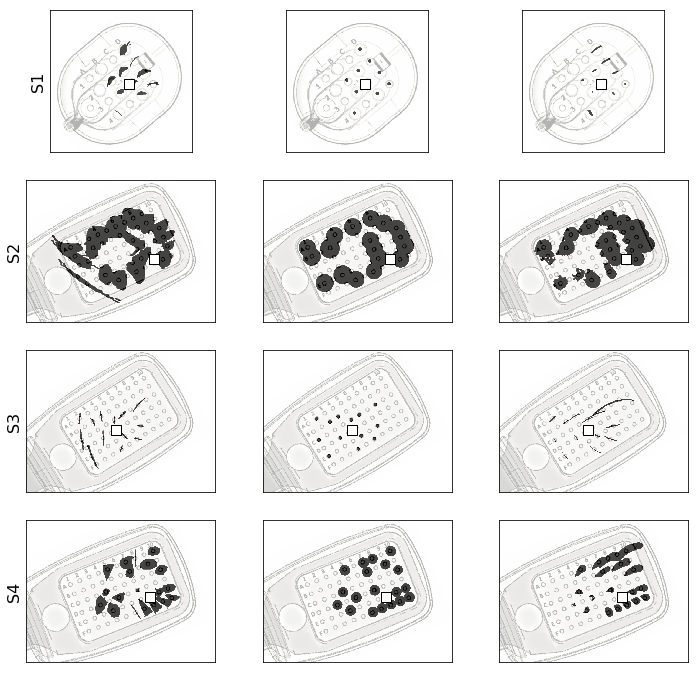

In [24]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=3, figsize=(12, 3 * len(subjects)))
for subject, axrow in zip(subjects, axes):
    for model, col, ax in zip(['A', 'A', 'C'], ['y_test', 'y_pred', 'y_pred'], axrow):
        yp = best[np.logical_and(best['subject'] == subject, best['model'] == model)][col].values[0]
        yp['subject'] = pd.Series([subject for _, _ in yp.iterrows()], index=yp.index)
        plot_phosphenes_on_array(ax, subject, yp, subjectdata)
        ax.set_xticks([])
        ax.set_yticks([])
    axrow[0].set_ylabel(subject, fontsize=16)
fig.savefig('fig7-model-scatter.png')